In [174]:
import pandas
import numpy
import os
import seaborn as sns

# !pip install gcastle torch

try:
    _SETUP
except NameError:
    os.chdir("..")
    _SETUP = True


X_test = pandas.read_pickle("data/X_test.pickle")
y_test = pandas.read_pickle("data/y_test.pickle")

ids = list(X_test.keys())

In [382]:
import networkx as nx
from typing import List, Union, Tuple
from scipy.stats import pearsonr, spearmanr, kendalltau
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from castle.metrics import MetricsDAG
import warnings

sns.set_theme()


def get_metrics(real: pandas.DataFrame, pred: pandas.DataFrame) -> dict:

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        metrics = MetricsDAG(real.values, pred.values).metrics

        real_skeleton = (real + real.T).clip(0, 1).copy()
        pred_skeleton = (pred + pred.T).clip(0, 1).copy()
        metrics2 = MetricsDAG(real_skeleton.values, pred_skeleton.values).metrics

        for metric in ["F1", "precision", "recall"]:
            metrics["skeleton_" + metric] = metrics2[metric]

    return metrics


def eyeball_test(xx: str, yy: str, data: pandas.DataFrame) -> None:
    """
    Plot a scatterplot and print correlation statistics between two variables.

    Args:
        xx: Name of first variable in data
        yy: Name of second variable in data
        data: DataFrame containing the variables
    """
    print(pearsonr(data[xx], data[yy]))
    print(spearmanr(data[xx], data[yy]))
    print(kendalltau(data[xx], data[yy]))
    sns.scatterplot(x=xx, y=yy, data=data)
    plt.show()


def show_mats(real: pandas.DataFrame, pred: pandas.DataFrame) -> None:
    """
    Visualize two adjacency matrices as directed graphs.

    Args:
        real: Adjacency matrix of the true graph
        pred: Adjacency matrix of the predicted graph
    """
    assert set(real.columns) == set(pred.columns), "Columns must be the same"

    G = nx.from_pandas_adjacency(real, create_using=nx.DiGraph)
    G1 = nx.from_pandas_adjacency(pred, create_using=nx.DiGraph)

    nx.draw_circular(G, with_labels=True, arrowsize=20, edge_color="black")
    nx.draw_circular(G1, with_labels=True, edge_color="red")

    plt.show()


def show_mat_diffs(
    real: pandas.DataFrame, pred: pandas.DataFrame, skeleton_only: bool = False
) -> dict:
    """
    Visualize two adjacency matrices as directed graphs.
    Red edges indicate missing edges (present in real but not in pred).
    Purple edges indicate incorrectly added edges (present in pred but not in real).

    Args:
        real: Adjacency matrix of the true graph
        pred: Adjacency matrix of the predicted graph
    """
    assert set(real.columns) == set(pred.columns), "Columns must be the same"

    if skeleton_only:
        real = (real + real.T).copy().clip(0, 1)
        pred = (pred + pred.T).copy().clip(0, 1)

    metrics = get_metrics(real, pred)

    diffs = (real - pred).copy()
    diffs_positive = diffs.clip(lower=0)  # Missing edges
    diffs_negative = -1 * diffs.clip(upper=0)  # Incorrectly added edges

    G = nx.from_pandas_adjacency(real, create_using=nx.DiGraph)
    diffs_pos = nx.from_pandas_adjacency(diffs_positive, create_using=nx.DiGraph)
    diffs_neg = nx.from_pandas_adjacency(diffs_negative, create_using=nx.DiGraph)

    plt.figure(figsize=(8, 6))

    # Draw true graph in background
    nx.draw_circular(
        G, with_labels=True, arrowsize=20, edge_color="black", alpha=0.3, width=4
    )
    # Draw missing edges in red
    nx.draw_circular(diffs_pos, with_labels=True, edge_color="red")
    # Draw incorrectly added edges in purple
    nx.draw_circular(diffs_neg, with_labels=True, edge_color="purple")

    legend_elements = [
        Line2D([0], [0], color="black", alpha=0.3, linewidth=4, label="True edges"),
        Line2D([0], [0], color="red", label="Missing edges"),
        Line2D([0], [0], color="purple", label="Incorrectly added edges"),
    ]
    plt.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.2))

    # Add metrics legend
    metrics_text = "\n".join(
        [f"{metric.upper()}: {metrics[metric]:.3f}" for metric in metrics.keys()]
    )
    plt.figtext(1, 0.6, metrics_text, va="center")

    plt.show()

    return metrics


def show_single_mat(real: pandas.DataFrame) -> None:
    """
    Visualize a single adjacency matrix as a directed graph.

    Args:
        real: Adjacency matrix to visualize
    """
    G = nx.from_pandas_adjacency(real, create_using=nx.DiGraph)
    nx.draw_circular(G, with_labels=True, arrowsize=20)
    plt.show()


def residualize(Z: List[str], yy: str, data: pandas.DataFrame) -> numpy.ndarray:
    """
    Calculate residuals after regressing yy on Z.

    Args:
        Z: List of variable names to use as predictors
        yy: Name of target variable
        data: DataFrame containing all variables

    Returns:
        Residuals from the regression
    """
    X_mat = data[Z].values
    y_vec = data[yy].values
    y_pred = X_mat @ numpy.linalg.lstsq(X_mat, y_vec, rcond=None)[0]
    res_y_x = y_vec - y_pred
    return res_y_x


def eyeball_test_confounders(
    xx: str, yy: str, Z: List[str], X: pandas.DataFrame
) -> None:
    """
    Plot relationship between two variables after controlling for confounders.

    Args:
        xx: Name of first variable
        yy: Name of second variable
        Z: List of confounder variable names
        X: DataFrame containing all variables
    """
    res1 = residualize(Z, xx, X)
    res2 = residualize(Z, yy, X)

    print(pearsonr(res1, res2))
    sns.regplot(x=res1, y=res2)
    plt.show()


def graph_nodes_representation(graph, nodelist):
    """
    Create an alternative representation of a graph which is hashable
    and equivalent graphs have the same hash.

    Python cannot PROPERLY use nx.Graph/DiGraph as key for
    dictionaries, because two equivalent graphs with just different
    order of the nodes would result in different keys. This is
    undesirable here.

    So here we transform the graph into an equivalent form that is
    based on a specific nodelist and that is hashable. In this way,
    two equivalent graphs, once transformed, will result in identical
    keys.

    So we use the following trick: extract the adjacency matrix
    (with nodes in a fixed order) and then make a hashable thing out
    of it, through tuple(array.flatten()):
    """

    # This get the adjacency matrix with nodes in a given order, as
    # numpy array (which is not hashable):
    adjacency_matrix = nx.adjacency_matrix(graph, nodelist=nodelist).todense()

    # This transforms the numpy array into a hashable object:
    hashable = tuple(adjacency_matrix.flatten())

    return hashable


def create_graph_label():
    """
    Create a dictionary from graphs to labels, in two formats.
    """

    graph_label = {
        nx.DiGraph([("X", "Y"), ("v", "X"), ("v", "Y")]): "Confounder",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("Y", "v")]): "Collider",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("v", "Y")]): "Mediator",
        nx.DiGraph([("X", "Y"), ("v", "X")]): "Cause of X",
        nx.DiGraph([("X", "Y"), ("v", "Y")]): "Cause of Y",
        nx.DiGraph([("X", "Y"), ("X", "v")]): "Consequence of X",
        nx.DiGraph([("X", "Y"), ("Y", "v")]): "Consequence of Y",
        nx.DiGraph({"X": ["Y"], "v": []}): "Independent",
    }

    nodelist = ["v", "X", "Y"]

    # This is an equivalent alternative to graph_label but in a form for which two equivalent graphs have the same key:
    adjacency_label = {
        graph_nodes_representation(graph, nodelist): label
        for graph, label in graph_label.items()
    }

    return graph_label, adjacency_label


def get_labels(adjacency_matrix, adjacency_label):
    """
    Transform an adjacency_matrix (as pandas.DataFrame) into a dictionary of variable:label
    """

    result = {}
    for variable in adjacency_matrix.columns.drop(["X", "Y"]):
        submatrix = adjacency_matrix.loc[
            [variable, "X", "Y"], [variable, "X", "Y"]
        ]  # this is not hashable
        key = tuple(
            submatrix.values.flatten()
        )  # this is hashable and compatible with adjacency_label

        result[variable] = adjacency_label[key]

    return result


def evaluate_predictions(results):
    graph_label, adjacency_label = create_graph_label()
    y_pred = []
    y_true = []
    for result in tqdm(results):
        try:
            A = result["y_hat"]
            if A is None:
                print(f"Empty prediction generated")
                continue
            y = result["y"]
        except Exception as e:
            print(f"Error in result {result}: {e}")
            continue

        predicted_label = get_labels(A, adjacency_label)
        ground_truth_label = get_labels(y, adjacency_label)

        for key in predicted_label.keys():
            y_pred.append(predicted_label[key])
            y_true.append(ground_truth_label[key])

    y_pred = pandas.Series(y_pred)
    y_true = pandas.Series(y_true)
    # Calculate Balanced Accuracy and Accuracy per class
    scores = {}

    for label in y_true.unique():
        scores[label] = numpy.mean(y_pred[y_true == label] == label)

    scores = pandas.Series(scores)
    scores["Balanced Accuracy"] = scores.mean()

    return scores


from typing import Callable, List
from tqdm.auto import tqdm


class Runner:
    def __init__(self, methods: dict[str, Callable], X_test: dict, y_test: dict):
        self.methods = methods
        self.X_test = X_test
        self.y_test = y_test

        self.y_hats = {}
        self.results = []

    def compare(self, test_ids: List[str], restrict_to_methods: List[str] = []) -> None:
        for _id in tqdm(test_ids, desc="IDs"):
            X = self.X_test[_id]
            y = self.y_test[_id]

            if _id not in self.y_hats:
                self.y_hats[_id] = {}

            for method_name, method in self.methods.items():
                if (
                    len(restrict_to_methods) > 0
                    and method_name not in restrict_to_methods
                ):
                    continue
                try:
                    pred = method(X)
                    self.y_hats[_id][method_name] = pred
                    metrics = get_metrics(y, pred)
                except Exception as e:
                    print(f"Error in method {method_name}: {e} for id {_id}")
                    self.y_hats[_id][method_name] = None
                    metrics = {}
                    continue

                metrics["method"] = method_name
                metrics["id"] = _id
                self.results.append(metrics)

    def get_results(self) -> pandas.DataFrame:
        return pandas.DataFrame(self.results)

    def add_methods(self, methods: dict[str, Callable]):
        new_methods = list(methods.keys())
        self.methods.update(methods)

        self.compare(list(self.y_hats.keys()), restrict_to_methods=new_methods)

    def evaluate(self) -> pandas.DataFrame:
        scores = []
        for method_name, _ in self.methods.items():
            results = [
                {"y_hat": self.y_hats[_id][method_name], "y": self.y_test[_id]}
                for _id in self.y_hats.keys()
            ]
            try:
                evaluation = evaluate_predictions(results)
                evaluation["method"] = method_name
                scores.append(evaluation)
            except Exception as e:
                print(
                    f"Error in method {method_name}. This is likely due to the fact that the graph is not a DAG or that an arrow from X to Y is missing.."
                )
                continue
        return pandas.DataFrame(scores)


def fix_DAG(g):
    """
    Ensure that the graph is a DAG and has an edge X→Y

    We look for cycles, and remove an edge in each cycle, until there are no cycles left.

    Inputs: g: nx.DiGraph
    Output: g: nx.DiGraph

    This function provides just a possible solution to the problem
    of DAG-ifying a graph. Other solutions can be conceived that could
    be better for the competition.
    """

    assert "X" in g.nodes
    assert "Y" in g.nodes

    gg = g.copy()

    # Add X→Y if it is missing
    if ("X", "Y") not in gg.edges:
        gg.add_edge("X", "Y")

    # Look for cycles and remove them
    while not nx.is_directed_acyclic_graph(gg):

        h = gg.copy()

        # Remove all the sources and sinks
        while True:
            finished = True

            for i, v in nx.in_degree_centrality(h).items():
                if v == 0:
                    h.remove_node(i)
                    finished = False

            for i, v in nx.out_degree_centrality(h).items():
                if v == 0:
                    h.remove_node(i)
                    finished = False

            if finished:
                break

        # Find a cycle, with a random walk starting at a random node
        node = list(h.nodes)[0]
        cycle = [node]
        while True:
            edges = list(h.out_edges(node))
            _, node = edges[numpy.random.choice(len(edges))]

            if node in cycle:
                break

            cycle.append(node)

        # We have a path that ends with a cycle: remove the begining, if it is not part of the cycle
        cycle = numpy.array(cycle)
        i = numpy.argwhere(cycle == node)[0][0]
        cycle = cycle[i:]
        cycle = cycle.tolist() + [node]

        # Edges in that cycle
        edges = list(zip(cycle[:-1], cycle[1:]))

        # Pick an edge at random, but make sure it is not X→Y -- we want to keep that one
        edges = [e for e in edges if e != ("X", "Y")]
        edge = edges[numpy.random.choice(len(edges))]

        gg.remove_edge(*edge)

    return gg


def fix_DAG_from_response_mat(response_mat: pandas.DataFrame) -> pandas.DataFrame:
    G = nx.from_pandas_adjacency(response_mat, create_using=nx.DiGraph)
    nodes = list(G.nodes)
    G = fix_DAG(G)

    return pandas.DataFrame(
        nx.to_numpy_array(G).astype(int), columns=nodes, index=nodes
    )


def find_correlated_pairs(corrMat, tol=0.9, upper_tol=1e-8):
    cols = list(corrMat.columns)
    results = []
    d = len(cols)

    for i in range(d):
        for j in range(i + 1, d):
            corr = corrMat.iloc[i, j]
            if (abs(corr) > tol) and ((1 - abs(corr)) > upper_tol):
                results.append((cols[i], cols[j]))

    return results


def fix_colinearity(X: pandas.DataFrame):
    corr_mat = X.corr()

    corr_pairs = find_correlated_pairs(corr_mat, 0.99, -1)
    all_nodes = []
    for elm in corr_pairs:
        all_nodes.append(elm[0])
        all_nodes.append(elm[1])
    all_nodes = list(set(all_nodes))
    X[all_nodes] = X[all_nodes] + numpy.random.normal(0, 0.001, X[all_nodes].shape)

In [304]:
a = None

a is None

True

# Let's explore the data

1. All variables are uniformely distributed from -1 to 1
2. The relationships are generally non-linear (and non-additive)
3. There contains some co-linearity between variables

I will cheat and already focus on one of the datasets that (in my opinion) represents the second point quite well.


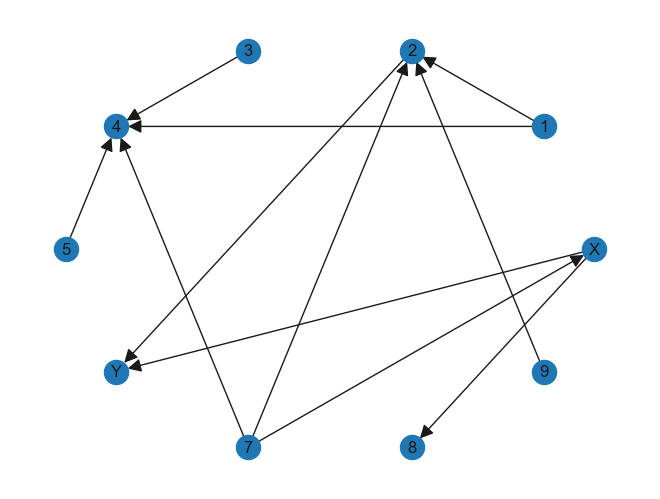

In [146]:
X = X_test[ids[3]]
y = y_test[ids[3]]


show_single_mat(y)

In this example we'll select two variables that are related, according to the causal graph, and see how their relationship actually looks like using a scatterplot.


PearsonRResult(statistic=-0.04496224496224496, pvalue=0.15538326867458)
SignificanceResult(statistic=-0.04496224496224496, pvalue=0.155383268674588)
SignificanceResult(statistic=-0.028624624624624624, pvalue=0.1752860438819268)


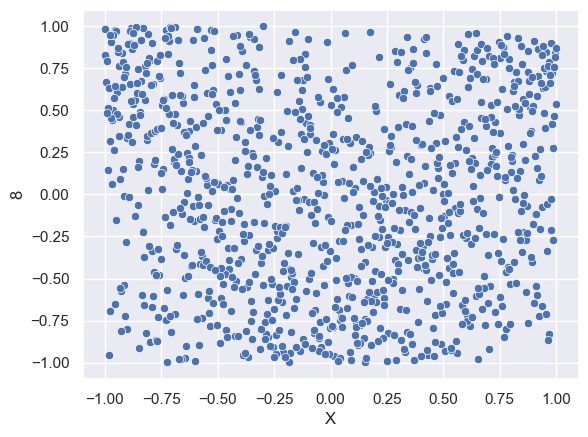

In [147]:
xx = "X"
yy = "8"

eyeball_test(xx, yy, X)

So it's pretty obvious that there is a relationship, although the relationship is highly non-linear, and obviously non-monotonic. If you just focus on the variance of Y given X, you can see that it's dependent.


<Axes: xlabel='X', ylabel='8'>

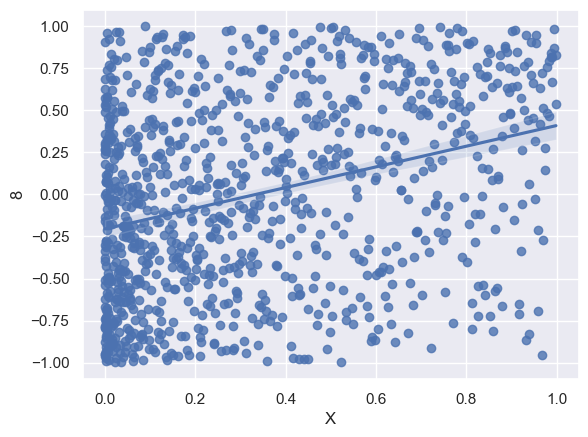

In [148]:
sns.regplot(x=X["X"] ** 2, y=X["8"])

On the flipside, we may also end up in situations where our inability to correctly model the copula means that we fail to remove edges that shouldn't be present. Let's consider the following example:


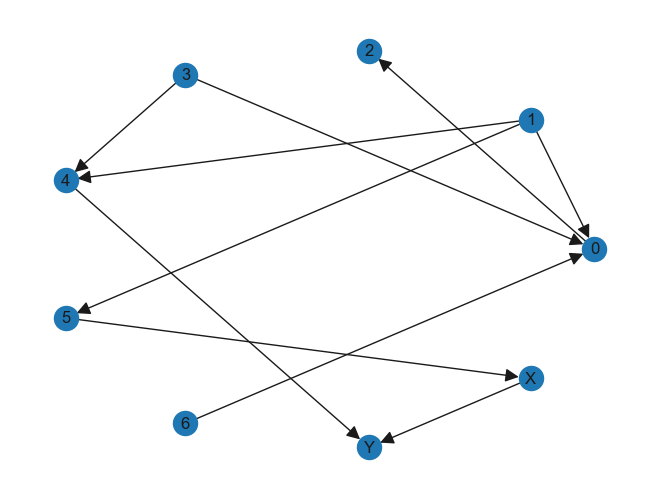

In [149]:
X = X_test[ids[4]]
y = y_test[ids[4]]

show_single_mat(y)

PearsonRResult(statistic=0.6885294765294766, pvalue=2.0217945110173292e-141)
SignificanceResult(statistic=0.6885294765294766, pvalue=2.0217945110173097e-141)
SignificanceResult(statistic=0.49933533533533536, pvalue=1.3550518014716119e-123)


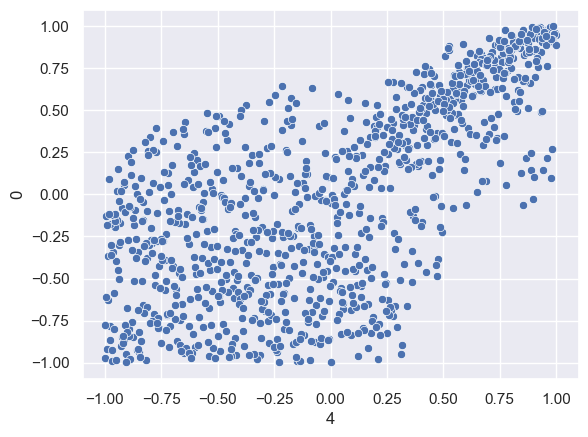

In [150]:
eyeball_test("4", "0", X)

Here it's a classic case where there's a somewhat linear relationship but with heteroskedasticity, and the residuals have a tiny skew as well. This relationship is spurious though, and we need to block "3" and "1" to remove it. Let's continue our linear exploration by doing it using partial pearson, and for simplicity we'll implement it using a linear regression.


PearsonRResult(statistic=0.07907002861254761, pvalue=0.012377205590119565)


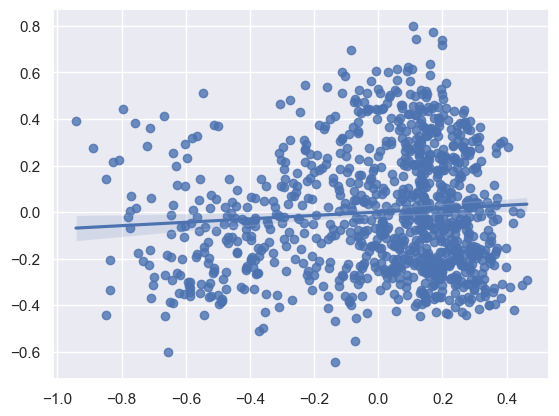

In [151]:
eyeball_test_confounders("0", "4", ["3", "1"], X)

So even though these should be independent given "3" and "1", we can see that there's still a residual relationship.


# Let's get down to business!

First we're gonna see how well we do on aggregate given some basic algorithms.


In [152]:
from magpy.oracles.oracles import CausalLearnOracle

In [153]:
oracle = CausalLearnOracle(X=X, oracle_name="fisherz", threshold=0.05)

In [154]:
from castle.algorithms import PC

In [368]:
from castle.common import GraphDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import PC, Notears
from castle.common import BaseLearner
from castle.common.priori_knowledge import PrioriKnowledge
import warnings
import logging

logging.getLogger().setLevel(logging.ERROR)


def get_priori_knowledge(X: pandas.DataFrame):
    columns = list(X.columns)
    index_of_X = columns.index("X")
    index_of_y = columns.index("Y")
    priori = PrioriKnowledge(X.values.shape[1])
    priori.add_required_edges([(index_of_X, index_of_y)])
    return priori


def run_gcastle_algo(
    X: pandas.DataFrame,
    algo: BaseLearner,
    algo_kwargs: dict = {},
    use_priori=True,
    force=True,
):
    # Fix colinearity
    fix_colinearity(X)

    if use_priori:
        priori = get_priori_knowledge(X)
        model = algo(priori_knowledge=priori, **algo_kwargs)
    else:
        model = algo(**algo_kwargs)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.learn(X.values)
    y_df = pandas.DataFrame(model.causal_matrix, columns=X.columns, index=X.columns)

    if force:
        y_df = fix_DAG_from_response_mat(y_df)

    return y_df

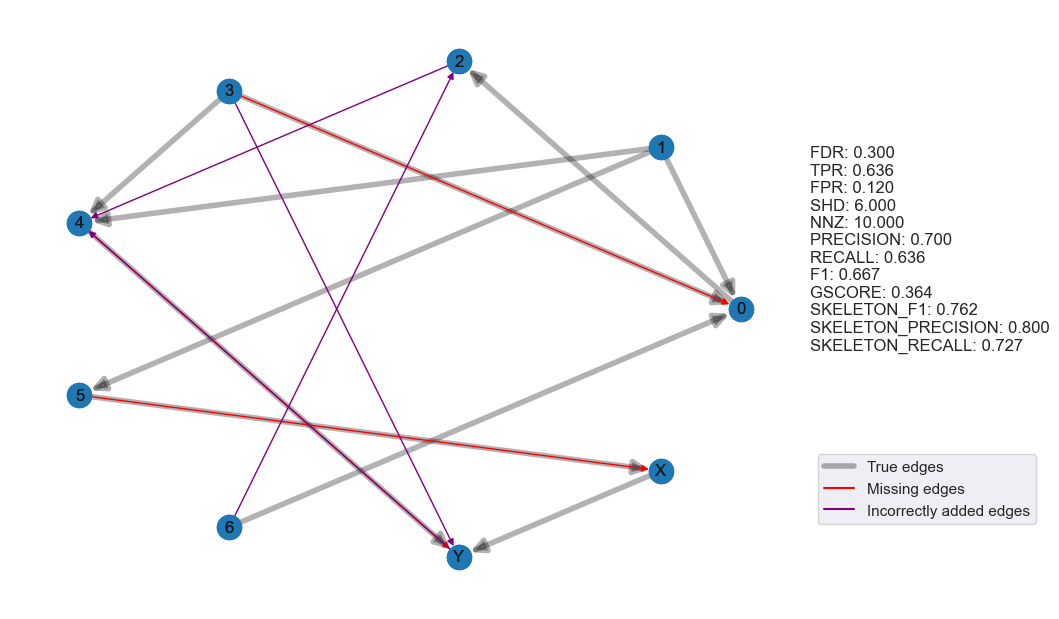

{'fdr': 0.3,
 'tpr': 0.6364,
 'fpr': 0.12,
 'shd': 6,
 'nnz': 10,
 'precision': 0.7,
 'recall': 0.6364,
 'F1': 0.6667,
 'gscore': 0.3636,
 'skeleton_F1': 0.7619,
 'skeleton_precision': 0.8,
 'skeleton_recall': 0.7273}

In [369]:
cg = run_gcastle_algo(X, PC, use_priori=True)
show_mat_diffs(y, cg)

In [388]:
from castle.algorithms import GES, DirectLiNGAM, Notears, PC


methods = {
    "notears": lambda X: run_gcastle_algo(X, Notears, use_priori=False),
    "pc": lambda X: run_gcastle_algo(X, PC, use_priori=True),
    "ges": lambda X: run_gcastle_algo(
        X, GES, use_priori=False, algo_kwargs={"criterion": "bic"}
    ),
    "lingam": lambda X: run_gcastle_algo(X, DirectLiNGAM, use_priori=False),
}

runner = Runner(methods=methods, X_test=X_test, y_test=y_test)

In [389]:
runner.compare(ids[:100])

results = runner.get_results()
metrics = sorted(list(set(results.columns) - {"method", "id"}))

mean_results = results.groupby("method")[metrics].mean()

IDs: 100%|██████████| 100/100 [04:42<00:00,  2.82s/it]


In [390]:
mean_results

,F1,fdr,fpr,gscore,nnz,precision,recall,shd,skeleton_F1,skeleton_precision,skeleton_recall,tpr
method,,,,,,,,,,,,
ges,0.632802,0.334516,0.410716,0.341940,11.29,0.665484,0.620334,7.64,0.802557,0.846791,0.784733,0.620334
lingam,0.440897,0.614309,0.507913,0.041389,11.29,0.385691,0.551613,8.94,0.675792,0.598601,0.827666,0.551613
notears,0.379943,0.722145,0.431742,0.021666,11.29,0.277855,0.682287,8.87,0.537418,0.395872,0.940686,0.682287
pc,0.600095,0.424771,0.418068,0.269144,11.29,0.575229,0.638109,7.00,0.784627,0.750309,0.837143,0.638109


In [411]:
# runner.evaluate()

So we have a starting point. We can get to 50% accuracy on the crunch metric with a direct search using BIC, and for PC we're at 38%.

This is an interesting observation, since "there's no free lunch": both methods are just using a linear model as a learner to build the graph, so why is that? My hypothesis is that the usage of v-structures is way more sensitive to the quality of the underlying learner than a direct search. If you look at the scores, you notice that the F1 of the skeleton search is somewhat similar between PC, which somehow corroborates this hunch. The precision/recall tradeoff for PC is not ideal either but we'll come back to that later.

Another observation is that while direct search methods scale quite poorly with the speed of the learner (we'll always need ± 2^nodes without any trimming), PC is more robust as long as the graph isn't fully connected.

So just by looking at this picture, we can come up with a strategy:

- Create a great oracle
- Use PC to generate the skeleton
- Figure out a way to orient it later with either direct search or some other method, given that the search space is already reduced.

The question is, how do we create a great oracle?

To do so, let me come with an engineering hammer and do the following:

- Create a way to separate the search from the oracle
- Create a way to generate oracles given any hypothesis about how the optimal "copula" should look like: i.e., for any y ~ f(X), how can I generate an oracle that will test this relationship?


Aside 1: Can we finally agree that notears is about as good as a random number generator? I know that someone will raise their hands and say something like "you haven't set it up appropriately, or consider this hyperparameter", but it's quite sad to see how people put notears in the same category as more robust algorithms. Causal discovery will never be taken seriously unless we decide to throw away stuff that **OBVIOUSLY** doesn't work, and it's clear that it has some fundamental issues (which other people in the academia have already pointed out). And the fact that it's in commercial products is just sad.


# The MagPy oracle

Aside 2: Corvids are probably one of the smartest animals on the planet. They know how to use tools and have a robust understanding of causality.


The idea (which probably is already documented in a paper somewhere) is quite simple:

- We want to test whether X is related to Y given Z
- We assume that there's some copula function f such that Y = f({S}) for any Y and potential set {S}
- We test Y ~ f(X, Z)
- We test Y ~ f(X)
- We check whether residuals improved enough from Y ~ f(X) to Y ~ f(X, Z), and create a pvalue p\_{XY}
- We do the same for X ~ f(Y, Z) and X ~ f(Y), and get a pvalue p\_{YX}
- We create a joint pvalue p\_{XY, YX} so that our test is symmetric.

Everything here is trivial with the exception of "how to create a pvalue given any choice of copula f"?

The reason why this is tricky is that if I have a very large model, I'm 100% sure to get a great improvement in sample just because I'm adding more degrees of freedom.

So I can either:

- Use some cross validation metric (expensive computationally)
- Just count the degrees of freedom for any given model and penalize for that (doesn't give me enough freedom when it comes to the types of algos I can use, since not every degree of freedom adds the same amount of "decrease in entropy" for different models - i.e., how would you do this counting for a decision tree that does a regression at the end?)

In any case, the latter makes more sense given this problem.


To actually create a pvalue given any model, all that we need is an RSS (residual sum of squares) and a degree of freedom count.

If we have the RSS of the "full model" and the "reduced model", we can create a pvalue quite easily using the F-test:


In [393]:
from scipy.stats import f


def get_f_and_p_val(
    rss_full: float, rss_reduced: float, p_full: int, p_reduced: int, n: int
) -> tuple[float, float]:
    F_stat = ((rss_reduced - rss_full) / (p_full - p_reduced)) / (
        rss_full / (n - p_full)
    )
    p_value: float = 1 - f.cdf(F_stat, p_full - p_reduced, n - p_full)  # type: ignore

    return F_stat, p_value

Let's create a simple example to illustrate the point. Here is a case where X and Y are independent given Z, but the relationship is obviously nonlinear.

If we use a linear test, we'll still get a relationship just because the oracle isn't fit for purpose (obviously)...


PearsonRResult(statistic=0.7102685865351073, pvalue=2.428342570387212e-154)


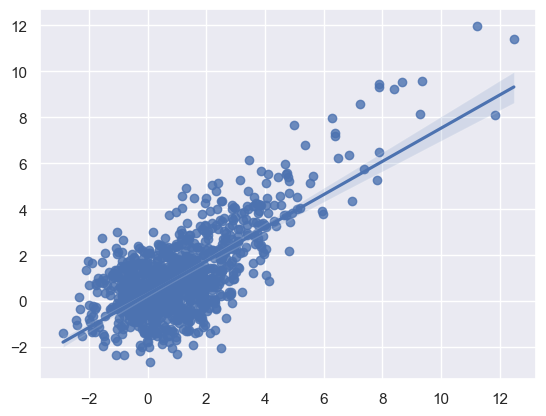

In [396]:
z = numpy.random.normal(0, 1, 1000)
y = z**2 + numpy.random.normal(0, 1, 1000)
x = z**2 + numpy.random.normal(0, 1, 1000)

df = pandas.DataFrame({"x": x, "y": y, "z": z})

eyeball_test_confounders("y", "x", ["z"], df)

In [401]:
from sklearn.preprocessing import PolynomialFeatures
from typing import Union, Optional


def poly_rss(
    X: Union[pandas.DataFrame, None],
    y: pandas.Series,
    node: Optional[str] = None,
    parent_set: Optional[set] = None,
    degree: int = 3,
):
    """Perform polynomial regression and return residual sum of squares and degrees of freedom.

    Args:
        X (Union[pandas.DataFrame, None]): Feature matrix. If None, only intercept is used.
        y (pandas.Series): Target variable.
        node (Optional[str], optional): Node name, not used but included for API compatibility. Defaults to None.
        parent_set (Optional[set], optional): Parent set, not used but included for API compatibility. Defaults to None.
        degree (int, optional): Degree of polynomial features. Defaults to 3.

    Returns:
        tuple: (rss, p)
            rss (float): Residual sum of squares from polynomial regression
            p (int): Number of parameters (degrees of freedom) in the model
    """

    if X is None:
        X_values = numpy.ones(shape=(y.shape[0], 1))

    else:
        X_values = X.values
        X_values = PolynomialFeatures(degree=degree).fit_transform(X_values)

    y_values: numpy.ndarray = y.values  # type: ignore

    _, [rss], _, _ = numpy.linalg.lstsq(X_values, y_values, rcond=None)

    p = X_values.shape[1]

    return rss, p


rss_full, p_full = poly_rss(df[["x", "z"]], df["y"], degree=2)
rss_reduced, p_reduced = poly_rss(df[["z"]], df["y"], degree=2)

ftest, p_value = get_f_and_p_val(rss_full, rss_reduced, p_full, p_reduced, df.shape[0])

print(p_value)

0.41258229489786047


Perfect, so now we have a way to generate pvalues from an arbitrary relationship, provided that we know how to count the degrees of freedom. So to implement an oracle all we need is to simmetrize it and we're done.
To simmetrize, we can come up with the following strategies:

        if self.operation == "mm":
            return min(2 * min(p1, p2), max(p1, p2))
        elif self.operation == "max":
            return max(p1, p2)
        elif self.operation == "min":
            return min(p1, p2)


REFERENCE: all this was inspired by: https://pmc.ncbi.nlm.nih.gov/articles/PMC6428307/, in that case the objective was mixed but the idea of the paper is the same (F-test or LL ratio to generate pvalues and symmetrize)


Let's try to see how that works in practice! All this is in a a BaseOracle class, which accepts any learner that has the format of poly_rss above, and spits out a proper oracle.


In [406]:
from magpy.search.pcskeleton import pc_skeleton
from magpy.oracles.oracles import BaseOracle, linear


oracle = BaseOracle(df, threshold=0.05, learner=linear)

print("linear: ")
print("independent: ", oracle("y", "x", ["z"]))
print("pvalue: ", oracle._run("y", "x", ["z"]))

oracle = BaseOracle(df, threshold=0.05, learner=poly_rss)

print("polynomial: ")
print("independent: ", oracle("y", "x", ["z"]))
print("pvalue: ", oracle._run("y", "x", ["z"]))

linear: 
independent:  False
pvalue:  1.1102230246251565e-16
polynomial: 
independent:  True
pvalue:  0.4960998287202051


Let's see how we perform now, and before we actually start building full graphs, we just want to see the skeleton measures by moving from linear to a polynomial model.

And as a remark, we'll be using our own implementation of the PC algorithm now, this orientation accepts any oracle, and has a special parameter called intersection_or_union which I'll describe later.


In [407]:
from magpy.oracles.oracles import linear, cubic


def pc_skeleton_magpy(
    X: pandas.DataFrame,
    learner: Callable = linear,
    intersection_or_union: str = "union",
):
    # Fix colinearity, this function just adds noise whenever the det of the corr matrix is close to 0
    fix_colinearity(X)

    oracle = BaseOracle(X, threshold=0.05, learner=learner)
    skeleton, sepsets = pc_skeleton(
        oracle, X.columns, intersection_or_union=intersection_or_union
    )
    return skeleton


runner.add_methods(
    {
        "pc_magpy_linear": lambda X: pc_skeleton_magpy(X, learner=linear),
        "pc_magpy_cubic": lambda X: pc_skeleton_magpy(X, learner=cubic),
    }
)

IDs: 100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


In [408]:
results = runner.get_results()
metrics = [x for x in results.columns if x.startswith("skeleton")]

mean_results = results.groupby("method")[metrics].mean()

In [410]:
mean_results.sort_values(by="skeleton_F1", ascending=False)

,skeleton_F1,skeleton_precision,skeleton_recall
method,,,
pc_magpy_cubic,0.873750,0.880439,0.887936
ges,0.802557,0.846791,0.784733
pc,0.784627,0.750309,0.837143
pc_magpy_linear,0.781093,0.721388,0.877362
lingam,0.675792,0.598601,0.827666
notears,0.537418,0.395872,0.940686


Ok, that's remarkable, we just added a few curvy lines and got a 10% improvement in the F1 score! Is this good enough? Well to answer that question we need to actually build a full graph on top of this. Let's start by using causallearn exact search algorithm.


Aside 2: This is the most frustrating thing ever, there are 10 different packages and none of them have the same API. Just doing something as simple as: I have a super graph, I want to learn a DAG from it, let's try different search algorithms, that's already a pain in the lower back.


In [432]:
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search


def composite_search(
    X: pandas.DataFrame,
    learner: Callable = cubic,
    intersection_or_union: str = "union",
    force=True,
):
    # Fix colinearity
    fix_colinearity(X)

    skeleton = pc_skeleton_magpy(
        X, intersection_or_union=intersection_or_union, learner=learner
    )
    super_graph = skeleton.values

    priors = skeleton.copy() * 0
    priors.loc["X", "Y"] = 1
    include_graph = priors.values

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        graph, stats = bic_exact_search(
            X.values, super_graph, include_graph=include_graph
        )

    y_df = pandas.DataFrame(graph, columns=X.columns, index=X.columns)

    if force:
        y_df = fix_DAG_from_response_mat(y_df)

    return y_df

In [426]:
runner.add_methods(
    {
        "cubic_pc_linear_bic": lambda X: composite_search(X, learner=cubic),
    }
)

IDs:  20%|██        | 20/100 [00:14<01:07,  1.19it/s]

Error in method cubic_pc_linear_bic: list index out of range for id 00392


IDs:  22%|██▏       | 22/100 [00:15<00:50,  1.56it/s]

Error in method cubic_pc_linear_bic: list index out of range for id 00422


IDs:  25%|██▌       | 25/100 [00:19<01:05,  1.14it/s]

Error in method cubic_pc_linear_bic: list index out of range for id 00452


IDs:  26%|██▌       | 26/100 [00:20<01:20,  1.09s/it]

Error in method cubic_pc_linear_bic: list index out of range for id 00461


IDs:  39%|███▉      | 39/100 [00:51<05:11,  5.10s/it]

Error in method cubic_pc_linear_bic: list index out of range for id 00836


IDs:  54%|█████▍    | 54/100 [01:10<01:13,  1.59s/it]

Error in method cubic_pc_linear_bic: list index out of range for id 01263


IDs:  56%|█████▌    | 56/100 [01:12<00:53,  1.21s/it]

Error in method cubic_pc_linear_bic: list index out of range for id 01267


IDs:  62%|██████▏   | 62/100 [01:16<00:21,  1.73it/s]

Error in method cubic_pc_linear_bic: list index out of range for id 01466


IDs:  68%|██████▊   | 68/100 [01:44<02:08,  4.02s/it]

Error in method cubic_pc_linear_bic: list index out of range for id 01679


IDs:  73%|███████▎  | 73/100 [01:49<00:38,  1.42s/it]

Error in method cubic_pc_linear_bic: list index out of range for id 01786


IDs:  74%|███████▍  | 74/100 [01:56<01:21,  3.13s/it]

Error in method cubic_pc_linear_bic: list index out of range for id 01814


IDs:  77%|███████▋  | 77/100 [01:57<00:32,  1.42s/it]

Error in method cubic_pc_linear_bic: list index out of range for id 01826


IDs:  83%|████████▎ | 83/100 [02:00<00:11,  1.46it/s]

Error in method cubic_pc_linear_bic: list index out of range for id 02112


IDs:  85%|████████▌ | 85/100 [02:01<00:07,  1.94it/s]

Error in method cubic_pc_linear_bic: list index out of range for id 02164


IDs:  97%|█████████▋| 97/100 [02:28<00:03,  1.16s/it]

Error in method cubic_pc_linear_bic: list index out of range for id 02471


IDs: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


,skeleton_F1,skeleton_precision,skeleton_recall
method,,,
pc_magpy_cubic,0.873750,0.880439,0.887936
cubic_pc_linear_bic,0.870948,0.847662,0.914196
ges,0.802557,0.846791,0.784733
pc,0.784627,0.750309,0.837143
pc_magpy_linear,0.781093,0.721388,0.877362
lingam,0.675792,0.598601,0.827666
notears,0.537418,0.395872,0.940686


In [428]:
results = runner.get_results()
metrics = sorted(list(set(results.columns) - {"method", "id"}))
mean_results = results.groupby("method")[metrics].mean()
mean_results.sort_values(by="F1", ascending=False)

,F1,fdr,fpr,gscore,nnz,precision,recall,shd,skeleton_F1,skeleton_precision,skeleton_recall,tpr
method,,,,,,,,,,,,
cubic_pc_linear_bic,0.719874,0.298331,0.298306,0.448826,11.00,0.701669,0.753044,4.517647,0.870948,0.847662,0.914196,0.753044
ges,0.632802,0.334516,0.410716,0.341940,11.29,0.665484,0.620334,7.640000,0.802557,0.846791,0.784733,0.620334
pc,0.600095,0.424771,0.418068,0.269144,11.29,0.575229,0.638109,7.000000,0.784627,0.750309,0.837143,0.638109
pc_magpy_cubic,0.583930,0.119561,0.414269,0.376532,11.29,0.880439,0.443965,3.220000,0.873750,0.880439,0.887936,1.443965
pc_magpy_linear,0.538278,0.278612,0.497095,0.261473,11.29,0.721388,0.438678,4.720000,0.781093,0.721388,0.877362,1.438678
lingam,0.440897,0.614309,0.507913,0.041389,11.29,0.385691,0.551613,8.940000,0.675792,0.598601,0.827666,0.551613
notears,0.379943,0.722145,0.431742,0.021666,11.29,0.277855,0.682287,8.870000,0.537418,0.395872,0.940686,0.682287


In [430]:
crunch_metrics = runner.evaluate()
crunch_metrics.sort_values(by="Balanced Accuracy", ascending=False)

  0%|          | 0/100 [00:00<?, ?it/s]


Error in method pc_magpy_linear. This is likely due to the fact that the graph is not a DAG or that an arrow from X to Y is missing..


  0%|          | 0/100 [00:00<?, ?it/s]


Error in method pc_magpy_cubic. This is likely due to the fact that the graph is not a DAG or that an arrow from X to Y is missing..


 36%|███▌      | 36/100 [00:00<00:00, 177.72it/s]

Empty prediction generated
Empty prediction generated
Empty prediction generated
Empty prediction generated


 75%|███████▌  | 75/100 [00:00<00:00, 184.60it/s]

Empty prediction generated
Empty prediction generated
Empty prediction generated
Empty prediction generated
Empty prediction generated
Empty prediction generated
Empty prediction generated


 94%|█████████▍| 94/100 [00:00<00:00, 183.36it/s]

Empty prediction generated
Empty prediction generated
Empty prediction generated


100%|██████████| 100/100 [00:00<00:00, 179.26it/s]

Empty prediction generated


,Confounder,Consequence of X,Collider,Consequence of Y,Independent,Cause of Y,Cause of X,Mediator,Balanced Accuracy,method
4,0.611111,0.483871,0.500000,0.592593,0.924623,0.750000,0.545455,0.277778,0.585679,cubic_pc_linear_bic
2,0.342105,0.392857,0.363636,0.515152,0.755459,0.685185,0.431373,0.200000,0.460721,ges
1,0.236842,0.250000,0.212121,0.363636,0.825328,0.685185,0.450980,0.040000,0.383012,pc
3,0.157895,0.214286,0.121212,0.393939,0.842795,0.351852,0.196078,0.040000,0.289757,lingam
0,0.000000,0.190476,0.000000,0.181818,0.960699,0.092593,0.156863,0.040000,0.202806,notears


Ok, now we're game! 59% is pretty close to a respectable score. But how we can we improve this?
Well let's look at the table below. This is the opposite of the behaviour I want.. I'm happy to trade recall for precision, since I will have more opportunities to remove edges, but once an edge is removed, I cannot add it again in my exact search.


In [431]:
mean_results.loc[
    "cubic_pc_linear_bic", ["skeleton_F1", "skeleton_precision", "skeleton_recall"]
]

skeleton_F1           0.870948
skeleton_precision    0.847662
skeleton_recall       0.914196
Name: cubic_pc_linear_bic, dtype: float64

The idea, without going into p_value optimization, is to break PC. In the PC skeleton search, suppose I find the following structure after step 0:

X - Y - Z

The the parent set over which I'm gonna run my CI test now for X-Y is {Z}, which is contained in the union of parents of X and Y. But that's too aggressive - in reality I just need it to consider the intersection of parents of X and Y in the conditioning set - more parents, more noise, more false positives.


In [433]:
runner.add_methods(
    {
        "cubic_pc_linear_bic_intersection": lambda X: composite_search(
            X, intersection_or_union="intersection", learner=cubic
        ),
    }
)

IDs:  39%|███▉      | 39/100 [00:27<02:38,  2.60s/it]

Error in method cubic_pc_linear_bic_intersection: list index out of range for id 00836


IDs:  54%|█████▍    | 54/100 [00:33<00:17,  2.65it/s]

Error in method cubic_pc_linear_bic_intersection: list index out of range for id 01263


IDs:  56%|█████▌    | 56/100 [00:34<00:19,  2.20it/s]

Error in method cubic_pc_linear_bic_intersection: list index out of range for id 01267


IDs:  62%|██████▏   | 62/100 [00:35<00:08,  4.27it/s]

Error in method cubic_pc_linear_bic_intersection: list index out of range for id 01466


IDs:  73%|███████▎  | 73/100 [00:46<00:13,  1.98it/s]

Error in method cubic_pc_linear_bic_intersection: list index out of range for id 01786


IDs:  78%|███████▊  | 78/100 [00:50<00:11,  1.95it/s]

Error in method cubic_pc_linear_bic_intersection: list index out of range for id 01826


IDs:  95%|█████████▌| 95/100 [00:59<00:02,  1.87it/s]

Error in method cubic_pc_linear_bic_intersection: list index out of range for id 02471


IDs: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


In [434]:
results = runner.get_results()
metrics = sorted(list(set(results.columns) - {"method", "id"}))
mean_results = results.groupby("method")[metrics].mean()
mean_results.sort_values(by="F1", ascending=False)

,F1,fdr,fpr,gscore,nnz,precision,recall,shd,skeleton_F1,skeleton_precision,skeleton_recall,tpr
method,,,,,,,,,,,,
cubic_pc_linear_bic_intersection,0.733867,0.263524,0.286275,0.493131,11.258065,0.736476,0.742728,4.795699,0.870723,0.874842,0.881448,0.742728
cubic_pc_linear_bic,0.719874,0.298331,0.298306,0.448826,11.000000,0.701669,0.753044,4.517647,0.870948,0.847662,0.914196,0.753044
ges,0.632802,0.334516,0.410716,0.341940,11.290000,0.665484,0.620334,7.640000,0.802557,0.846791,0.784733,0.620334
pc,0.600095,0.424771,0.418068,0.269144,11.290000,0.575229,0.638109,7.000000,0.784627,0.750309,0.837143,0.638109
pc_magpy_cubic,0.583930,0.119561,0.414269,0.376532,11.290000,0.880439,0.443965,3.220000,0.873750,0.880439,0.887936,1.443965
pc_magpy_linear,0.538278,0.278612,0.497095,0.261473,11.290000,0.721388,0.438678,4.720000,0.781093,0.721388,0.877362,1.438678
lingam,0.440897,0.614309,0.507913,0.041389,11.290000,0.385691,0.551613,8.940000,0.675792,0.598601,0.827666,0.551613
notears,0.379943,0.722145,0.431742,0.021666,11.290000,0.277855,0.682287,8.870000,0.537418,0.395872,0.940686,0.682287


We haven't improved much the performance, but we've moved a bit of recall to precision on the skeleton, which is what we wanted. Anyway, now we need to actually improve the performance of the search algorithm.

Now, let's understand how exact search works:

- We start with a super graph, which is the skeleton
- For each node, we consider all subsets of parents of that node which is consistent with the super graph
- We score the parent set of the node using a scoring function y ~f({S}), for each parent set {S}
- We now start adding edges to the graph, and then score the new graph by the sum of the scores of the individual nodes given the parent set in the graph
- We choose the DAG with the best score of all.

Now each search algorithm will do it in a slightly different way, but the idea is the same. One blob that will score parent sets, another blob that will turn parent sets scores into a DAG.


The question is, how do we score parent sets? The standard way is to use the BIC score:

BIC = $n \log(\frac{RSS}{n}) + k \log(n)$

where:

- n is the sample size
- RSS is the residual sum of squares from the regression
- k is the number of parameters (parent set size)


Because we just created a learner that sort of works for this (cubic), let's actually use it to try to score the parent sets.


In [437]:
# you will notice that this function has deceivingly almost the same format as the poly_rss function we created earlier, but I was silly enough to change the y and X positions between these two definitinos, which
# I'll fix at some point.


def bic_score_node_poly(
    y,
    X=None,
    node: str | None = None,
    parent_set: set | None = None,
    degree=3,
    include_bias=True,
):
    n = len(y)

    if X is None:
        residual = numpy.sum(y**2)
        dof = 0

    else:
        Xf = PolynomialFeatures(degree=degree, include_bias=include_bias).fit_transform(
            X
        )
        n, dof = Xf.shape
        _, residual, _, _ = numpy.linalg.lstsq(a=Xf, b=y, rcond=None)

    bic = n * numpy.log(residual / n) + dof * numpy.log(n)
    return bic.item()

Let's see how it works in the scenario we created earlier (lower is better!).

The DGP is:

- $Y = Z^2 + noise$
- $X = Z^2 + noise$


In [451]:
a = bic_score_node_poly(df["y"], df[["x"]])
b = bic_score_node_poly(df["y"], df[["x", "z"]])
c = bic_score_node_poly(df["y"], df[["z"]])

print("X -> Y", a)
print("X -> Y, Z -> Y", b)
print("Z -> Y", c)

X -> Y 369.71231381369637
X -> Y, Z -> Y 43.26549803724161
Z -> Y 7.242180802681165


We also gained a superpower here. A linear BIC is symmetric (i.e, we can't tell the difference between X -> Y and Y -> X). But here we come with a functional prior that tells us that X -> Y is different from Y -> X.

Furthermore, if our DGP is non bijective, this will give us a clear pattern in the data which will reflect itself in the RSS.


In [449]:
print("Y -> Z", bic_score_node_poly(df["z"], df[["y"]]))
print("Z -> Y", bic_score_node_poly(df["y"], df[["z"]]))

Y -> Z 65.79319037053794
Z -> Y 7.242180802681165
